In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["font.family"] = "Times New Roman" # Set font to Times New Roman
import sys
import os


# Add the repo root (one level up from notebooks) to Python path
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(repo_root)

# Real data helpers
from data.data_loader import fetch_stock_data,fetch_current_chain
from src.volatility import implied_volatility
from src import strategies
from src.utils import (
        make_roll_calendar,
        rolling_annualized_vol,
        remaining_T_in_years,
        infer_atm_strike,
    )



In [2]:
TICKER = "AAPL"            # e.g., "AAPL", "QQQ", "MSFT"
START  = "2018-01-01"
END    = "2025-01-01"     # or None for full history

# Expect a DataFrame with 'Close'
px = fetch_stock_data(TICKER, start=START, end=END)
px = px[["Close"]].rename(columns={"Close": "close"}).dropna()
px.head(3)


[*********************100%***********************]  1 of 1 completed


Price,close
Ticker,AAPL
Date,
2018-01-02,40.381008
2018-01-03,40.373962
2018-01-04,40.561497


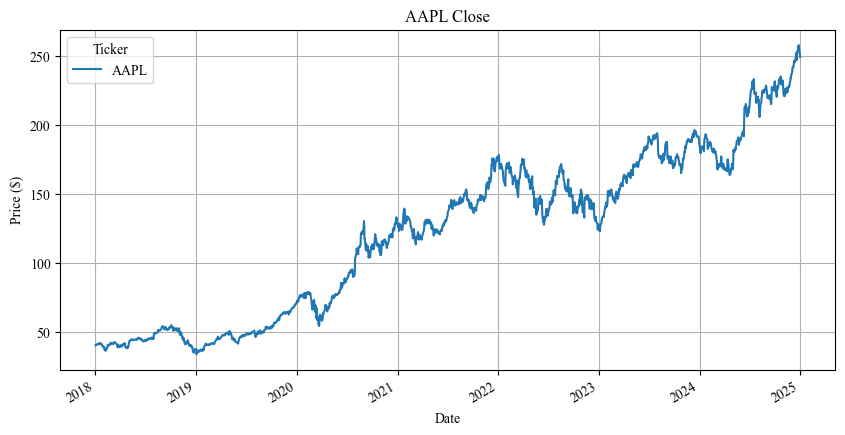

In [3]:
px["close"].plot(title=f"{TICKER} Close")
plt.grid(True); plt.ylabel("Price ($)")
plt.show()


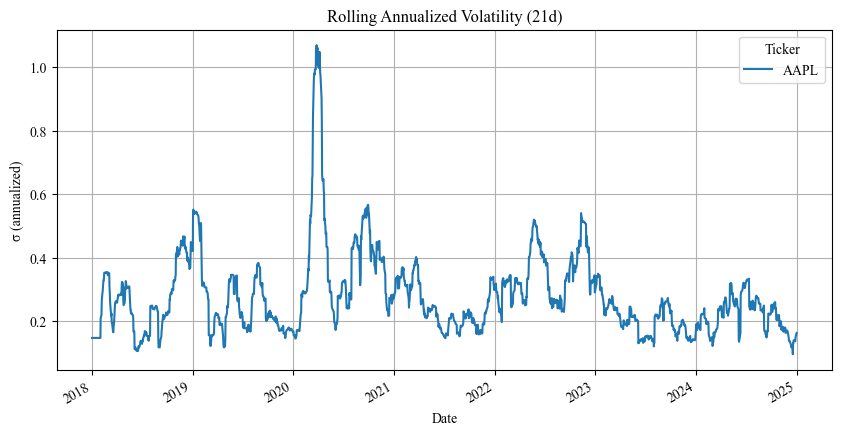

In [4]:
sigma = rolling_annualized_vol(px["close"], window=21)
sigma.name = "sigma"

# sanity peek
sigma.plot(title="Rolling Annualized Volatility (21d)")
plt.grid(True); plt.ylabel("σ (annualized)")
plt.show()


In [5]:
schedule      = "monthly"  # or "weekly"
holding_days  = 21         # ~1 month
r             = 0.03       # flat risk-free

roll_dates = make_roll_calendar(px.index, schedule=schedule)
len(roll_dates), roll_dates[:5]


(84,
 DatetimeIndex(['2018-01-02', '2018-02-01', '2018-03-01', '2018-04-02',
                '2018-05-01'],
               dtype='datetime64[ns]', name='Date', freq=None))

In [6]:
def backtest_strategies(
    px,
    sigma,
    strategies_to_run,
    holding_days=21,
    r=0.03,
    schedule="monthly",
    strike_step=None,
    strategy_params=None,   # NEW: dict of per-strategy kwargs (e.g., {"bull_call_spread": {"dK":10}})
):
    """
    Stepwise (expiry-only) PnL accumulation backtest.

    Parameters
    ----------
    px : DataFrame with 'close'
    sigma : Series of annualized vols (aligned or alignable to px.index)
    strategies_to_run : iterable[str]
        Names understood by price_strategy(...) (e.g., "long_call", "straddle", "bull_call_spread", ...)
    holding_days : int
        How many trading days to hold each leg (≈ expiry)
    r : float
        Flat risk-free rate
    schedule : {"monthly","weekly"}
        Roll frequency (first trading day of month, or all chosen weekday in util)
    strike_step : float or None
        If provided, ATM strike will be rounded to nearest multiple (e.g., 1, 2.5, 5)
    strategy_params : dict[str, dict] or None
        Per-strategy kwargs forwarded to price_strategy, e.g.
        {"bull_call_spread": {"dK": 10}, "strangle": {"K1": K-15, "K2": K+15}}
    """
    strategy_params = strategy_params or {}

    idx = px.index
    roll_dates = make_roll_calendar(idx, schedule=schedule)
    roll_dates = roll_dates[roll_dates <= idx[-1]]

    out = pd.DataFrame(index=idx)
    out["S"] = px["close"]
    out["sigma"] = sigma.reindex(idx).ffill().bfill()

    # cumulative PnL storage
    for name in strategies_to_run:
        out[f"{name}_cum_pnl"] = 0.0

    # loop over rolls
    for roll_dt in roll_dates:
        # locate start/expiry
        start_i = idx.get_indexer_for([roll_dt])[0]
        end_i   = min(start_i + holding_days, len(idx) - 1)
        expiry_dt = idx[end_i]

        # entry state
        S0   = float(px.loc[roll_dt, "close"])
        K    = infer_atm_strike(S0, step=strike_step)
        sig0 = float(out.loc[roll_dt, "sigma"])
        T0   = remaining_T_in_years(roll_dt, expiry_dt, roll_dt)

        # entry values
        entry_vals = {}
        for name in strategies_to_run:
            kwargs = strategy_params.get(name, {})
            entry_vals[name] = price_strategy(name, S0, K, T0, r, sig0, **kwargs)

        # exit state (at expiry)
        S_T  = float(px.loc[expiry_dt, "close"])
        sigT = float(out.loc[expiry_dt, "sigma"])
        TT   = remaining_T_in_years(roll_dt, expiry_dt, expiry_dt)  # ~0

        # exit values
        exit_vals = {}
        for name in strategies_to_run:
            kwargs = strategy_params.get(name, {})
            exit_vals[name] = price_strategy(name, S_T, K, TT, r, sigT, **kwargs)

        # realize leg PnL and stepwise cum carry
        for name in strategies_to_run:
            leg_pnl = exit_vals[name] - entry_vals[name]
            out.loc[expiry_dt:, f"{name}_cum_pnl"] += leg_pnl

    return out


In [7]:
def price_strategy(name, S, K, T, r, sig, **kwargs):
    """
    Unified strategy pricer that handles everything in strategies.py PLUS calendars.

    Supports names:
      - long_call, short_call, long_put, short_put
      - straddle, strangle, collar
      - bull_call_spread, bear_put_spread, butterfly_spread
      - covered_call (fallback = stock - call if not in strategies.py)
      - calendar_call, calendar_put  <-- NEW (T_short vs T_long, per-leg vols)

    Extra kwargs:
      dK, K1, K2, K3, K_put, K_call
      T_short, T_long
      sig_short, sig_long   # per-leg vols for calendars (else falls back to 'sig')
    """
    name_l = name.lower()
    dK  = float(kwargs.get("dK", 5.0))

    # derive extra strikes if needed
    K1     = kwargs.get("K1", None)
    K2     = kwargs.get("K2", None)
    K3     = kwargs.get("K3", None)
    K_put  = kwargs.get("K_put", None)
    K_call = kwargs.get("K_call", None)

    if name_l == "strangle":
        K1 = K1 if K1 is not None else (K - dK)
        K2 = K2 if K2 is not None else (K + dK)
    elif name_l == "bull_call_spread":
        K1 = K1 if K1 is not None else K
        K2 = K2 if K2 is not None else (K + dK)
    elif name_l == "bear_put_spread":
        K1 = K1 if K1 is not None else K
        K2 = K2 if K2 is not None else (K - dK)
    elif name_l == "butterfly_spread":
        K1 = K1 if K1 is not None else (K - dK)
        K2 = K2 if K2 is not None else K
        K3 = K3 if K3 is not None else (K + dK)
    elif name_l == "collar":
        K_put  = K_put  if K_put  is not None else (K - dK)
        K_call = K_call if K_call is not None else (K + dK)

    # calendars: per-leg T and sigma
    T_short = kwargs.get("T_short", T)
    T_long  = kwargs.get("T_long", 2.0 * T if T > 0 else T)
    sig_short = kwargs.get("sig_short", sig)
    sig_long  = kwargs.get("sig_long",  sig)

    # ===== expiry guard =====
    eps = 1e-12
    if T <= eps:  # used by most non-calendar names
        c = lambda s, k: max(s - k, 0.0)
        p = lambda s, k: max(k - s, 0.0)
        if name_l == "long_call":   return c(S, K)
        if name_l == "short_call":  return -c(S, K)
        if name_l == "long_put":    return p(S, K)
        if name_l == "short_put":   return -p(S, K)
        if name_l == "straddle":    return c(S, K) + p(S, K)
        if name_l == "strangle":
            k_low, k_high = min(K1, K2), max(K1, K2)
            return p(S, k_low) + c(S, k_high)
        if name_l == "collar":      return p(S, K_put) - c(S, K_call)
        if name_l == "bull_call_spread":
            k_low, k_high = min(K1, K2), max(K1, K2)
            return c(S, k_low) - c(S, k_high)
        if name_l == "bear_put_spread":
            k_low, k_high = min(K1, K2), max(K1, K2)
            return p(S, k_high) - p(S, k_low)
        if name_l == "butterfly_spread":
            ks = sorted([K1, K2, K3])
            return c(S, ks[0]) - 2.0 * c(S, ks[1]) + c(S, ks[2])
        if name_l == "covered_call": return S - c(S, K)
        # For calendars at the short expiry: short leg -> intrinsic 0, long leg valued with TT_long given via kwargs below

    # ===== pricing via strategies.py (T>0) =====
    if name_l == "long_call":   return strategies.long_call(S, K, T, r, sig)
    if name_l == "short_call":  return strategies.short_call(S, K, T, r, sig)
    if name_l == "long_put":    return strategies.long_put(S, K, T, r, sig)
    if name_l == "short_put":   return strategies.short_put(S, K, T, r, sig)
    if name_l == "straddle":    return strategies.straddle(S, K, T, r, sig)
    if name_l == "strangle":
        k_low, k_high = min(K1, K2), max(K1, K2)
        return strategies.strangle(S, k_low, k_high, T, r, sig)
    if name_l == "collar":            return strategies.collar(S, K_put, K_call, T, r, sig)
    if name_l == "bull_call_spread":  return strategies.bull_call_spread(S, min(K1,K2), max(K1,K2), T, r, sig)
    if name_l == "bear_put_spread":   return strategies.bear_put_spread(S, max(K1,K2), min(K1,K2), T, r, sig)
    if name_l == "butterfly_spread":
        ks = sorted([K1, K2, K3])
        return strategies.butterfly_spread(S, ks[0], ks[1], ks[2], r, T, sig)

    # calendars: long longer-dated; short shorter-dated; same strike
    if name_l == "calendar_call":
        val_long  = strategies.long_call(S, K, max(T_long, 0.0), r, sig_long)
        val_short = strategies.short_call(S, K, max(T_short, 0.0), r, sig_short)
        return val_long + val_short
    if name_l == "calendar_put":
        val_long  = strategies.long_put(S, K, max(T_long, 0.0), r, sig_long)
        val_short = strategies.short_put(S, K, max(T_short, 0.0), r, sig_short)
        return val_long + val_short

    if name_l == "covered_call":
        try:
            return strategies.covered_call(S, K, T, r, sig)
        except AttributeError:
            return S - strategies.long_call(S, K, T, r, sig)

    raise ValueError(f"Unknown strategy: {name}")


In [8]:
# Run backtest with single- and multi-leg strategies (incl. spreads)
strategies_to_run = [
    "long_call",
    "long_put",
    "straddle",
    "strangle",
    "bull_call_spread",
    "bear_put_spread",
    "butterfly_spread",
    "collar",
    "covered_call",   # fallback handled if not in strategies.py
]

# Per-strategy parameters (widths/extra strikes). Tweak as you like.
strategy_params = {
    "bull_call_spread": {"dK": 10},   # K2 = K + 10
    "bear_put_spread":  {"dK": 10},   # K2 = K - 10
    "butterfly_spread": {"dK": 20},   # K1=K-20, K2=K, K3=K+20
    "strangle":         {"dK": 15},   # K_put=K-15, K_call=K+15
    "collar":           {"dK": 10},   # if K_put/K_call not given, use ±dK
}

import warnings; warnings.filterwarnings("ignore")

res = backtest_strategies(
    px, sigma, strategies_to_run,
    holding_days=holding_days, r=r, schedule=schedule,
    strike_step=1,                    # round ATM strike to nearest 1
    strategy_params=strategy_params   # NEW: pass per-strategy kwargs
)

res.tail(3)


,S,sigma,long_call_cum_pnl,long_put_cum_pnl,straddle_cum_pnl,strangle_cum_pnl,bull_call_spread_cum_pnl,bear_put_spread_cum_pnl,butterfly_spread_cum_pnl,collar_cum_pnl,covered_call_cum_pnl
Date,,,,,,,,,,,
2024-12-27,254.685867,0.149779,68.878384,-98.085254,-29.206870,-75.090607,85.160953,-32.530913,-23.521787,-49.271772,133.722247
2024-12-30,251.307877,0.160823,68.878384,-98.085254,-29.206870,-75.090607,85.160953,-32.530913,-23.521787,-49.271772,133.722247
2024-12-31,249.534180,0.162739,74.327405,-102.604240,-28.276835,-76.339317,91.642085,-35.856381,-24.885144,-49.433179,139.064929


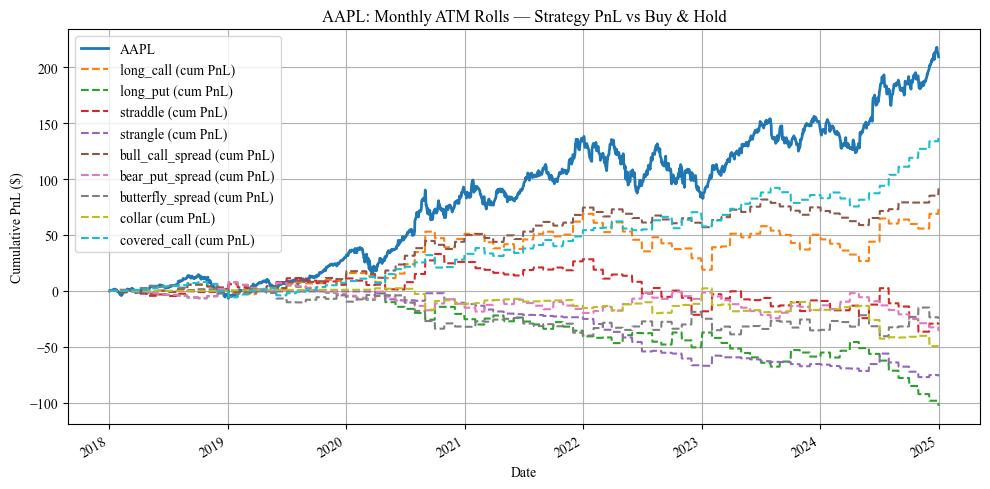

In [9]:
bh = px["close"] - px["close"].iloc[0]
ax = bh.plot(label="Buy & Hold (1x stock)", linewidth=2)

for name in strategies_to_run:
    res[f"{name}_cum_pnl"].plot(ax=ax, linestyle="--", label=f"{name} (cum PnL)")

plt.title(f"{TICKER}: {schedule.capitalize()} ATM Rolls — Strategy PnL vs Buy & Hold")
plt.ylabel("Cumulative PnL ($)")
plt.grid(True); plt.legend()
plt.tight_layout(); plt.show()


In [10]:
def summarize(res, strategies_to_run, px, schedule, holding_days):
    idx = res.index
    roll_dates = make_roll_calendar(idx, schedule=schedule)
    nlegs = 0
    for rd in roll_dates:
        i = idx.get_indexer_for([rd])[0]
        if i + holding_days < len(idx):
            nlegs += 1

    rows = []
    for name in strategies_to_run:
        total_pnl = float(res[f"{name}_cum_pnl"].iloc[-1])
        avg_per_leg = total_pnl / nlegs if nlegs > 0 else np.nan
        rows.append([name, total_pnl, nlegs, avg_per_leg])

    # Buy & Hold baseline
    bh_total = float(px["close"].iloc[-1] - px["close"].iloc[0])
    rows.append(["buy_hold", bh_total, np.nan, np.nan])

    df = pd.DataFrame(rows, columns=["strategy", "total_pnl", "n_legs", "avg_pnl_per_leg"])
    return df

summary = summarize(res, strategies_to_run, px, schedule, holding_days)
summary


,strategy,total_pnl,n_legs,avg_pnl_per_leg
0,long_call,74.327405,83.0,0.895511
1,long_put,-102.604240,83.0,-1.236196
2,straddle,-28.276835,83.0,-0.340685
3,strangle,-76.339317,83.0,-0.919751
4,bull_call_spread,91.642085,83.0,1.104122
5,bear_put_spread,-35.856381,83.0,-0.432005
6,butterfly_spread,-24.885144,83.0,-0.299821
7,collar,-49.433179,83.0,-0.595580
8,covered_call,139.064929,83.0,1.675481
9,buy_hold,209.153172,NaN,NaN


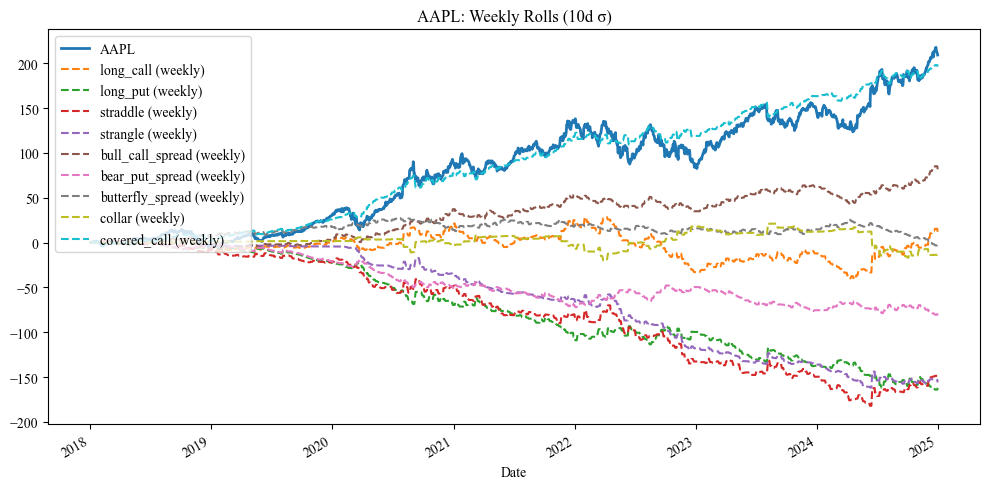

In [11]:
# Example: weekly rolls with 10-day vol
sigma_w10 = rolling_annualized_vol(px["close"], window=10)
res_w = backtest_strategies(px, sigma_w10, strategies_to_run, holding_days=5, r=r, schedule="weekly", strike_step=1)

ax = (px["close"] - px["close"].iloc[0]).plot(label="Buy & Hold", linewidth=2)
for name in strategies_to_run:
    res_w[f"{name}_cum_pnl"].plot(ax=ax, linestyle="--", label=f"{name} (weekly)")
plt.title(f"{TICKER}: Weekly Rolls (10d σ)")
plt.legend(loc="upper left", bbox_to_anchor=(0, 1)); plt.tight_layout(); plt.show()
